# **Импорт библиотек**

In [ ]:
!pip install medpy
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 13.8 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-cp310-cp310-linux_x86_64.whl size=762839 sha256=c3d4ace1489f1727bce69919cc047ce5546cb8c3f23f27b48641a7d41035665c
  Stored in directory: /root/.cache/pip/wheels/a1/b8/63/bdf557940ec60d1b8822e73ff9fbe7727ac19f009d46b5d175
Successfully built medpy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [ ]:
from google.colab import auth, drive
from googleapiclient.discovery import build

auth.authenticate_user()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, cm

from medpy.metric import dc, jc
from medpy.io import load, header

from sklearn.model_selection import train_test_split as tts

from tqdm import tqdm_notebook, trange

SEED = 42

# **Подготовка данных**

In [ ]:
def path():
    return f'drive/My Drive/8'

def get_data():
    X_path = path()
    X_filenames = []
    y_filenames = []
    if os.path.isdir(X_path):
        for filename in tqdm_notebook(os.listdir(X_path), position=0):
            filepath = os.path.join(X_path, filename)
            if ".dcm" in filename.lower():
                X_filenames.append(filepath)
            if ".png" in filename.lower():
                y_filenames.append(filepath)
    else:
        print(f"Директория {X_path} не существует")

    assert len(X_filenames) == len(y_filenames), "Количество файлов .dcm и .png не совпадает."
    return sorted(X_filenames), sorted(y_filenames)

In [ ]:
X_filenames, y_filenames = get_data()

print(f"Найдено {len(X_filenames)} файлов .dcm и {len(y_filenames)} файлов .png.")
print(X_filenames)
print(y_filenames)

<ipython-input-4-3dfe649b8256>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for filename in tqdm_notebook(os.listdir(X_path), position=0):


  0%|          | 0/246 [00:00<?, ?it/s]

Найдено 123 файлов .dcm и 123 файлов .png.
['drive/My Drive/8/i0000,0000b.dcm', 'drive/My Drive/8/i0001,0000b.dcm', 'drive/My Drive/8/i0002,0000b.dcm', 'drive/My Drive/8/i0003,0000b.dcm', 'drive/My Drive/8/i0004,0000b.dcm', 'drive/My Drive/8/i0005,0000b.dcm', 'drive/My Drive/8/i0006,0000b.dcm', 'drive/My Drive/8/i0007,0000b.dcm', 'drive/My Drive/8/i0008,0000b.dcm', 'drive/My Drive/8/i0009,0000b.dcm', 'drive/My Drive/8/i0010,0000b.dcm', 'drive/My Drive/8/i0011,0000b.dcm', 'drive/My Drive/8/i0012,0000b.dcm', 'drive/My Drive/8/i0013,0000b.dcm', 'drive/My Drive/8/i0014,0000b.dcm', 'drive/My Drive/8/i0015,0000b.dcm', 'drive/My Drive/8/i0016,0000b.dcm', 'drive/My Drive/8/i0017,0000b.dcm', 'drive/My Drive/8/i0018,0000b.dcm', 'drive/My Drive/8/i0019,0000b.dcm', 'drive/My Drive/8/i0020,0000b.dcm', 'drive/My Drive/8/i0021,0000b.dcm', 'drive/My Drive/8/i0022,0000b.dcm', 'drive/My Drive/8/i0023,0000b.dcm', 'drive/My Drive/8/i0024,0000b.dcm', 'drive/My Drive/8/i0025,0000b.dcm', 'drive/My Drive/8/i0

# **Буферизация изображений**

In [ ]:
def buffer_imgs(filenames, is_dicom, folder='buffer'):
    files = []
    if not os.path.exists(folder):
        os.makedirs(folder)
    for filename in tqdm_notebook(filenames, position=0):
        img, header = load(filename)
        pil = Image.fromarray(img.squeeze())
        fname = folder + '/' + filename.replace('/', '-')
        if is_dicom:
            fname = fname+'.tiff'
            pil.save(fname, 'TIFF', compression='none')
        else:
            pil.save(fname, fname.split('.')[-1], compression='none')
        files.append(fname)
    return pd.DataFrame(files)

# **Разделение данных на тренировочные и тестовые**

In [ ]:
X = buffer_imgs(X_filenames, True)
y = buffer_imgs(y_filenames, False)

<ipython-input-6-c77ba89e7316>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for filename in tqdm_notebook(filenames, position=0):


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

In [ ]:
X.shape, y.shape

((123, 1), (123, 1))

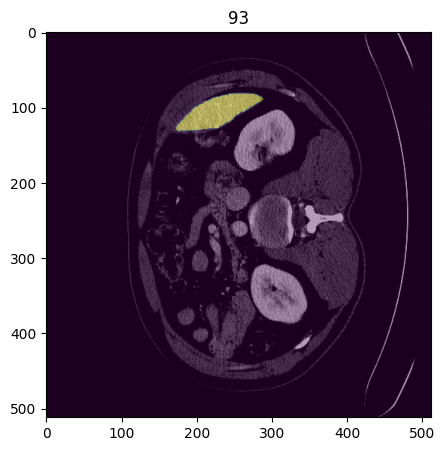

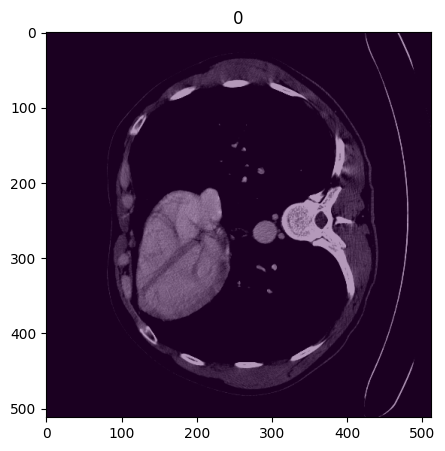

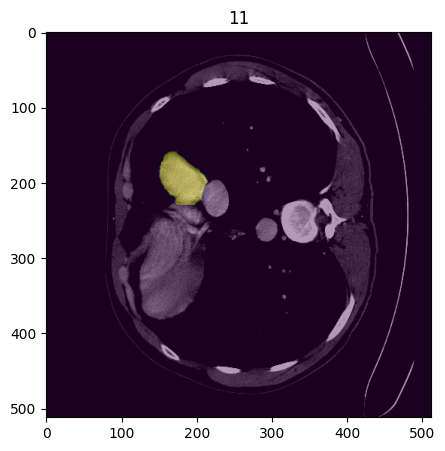

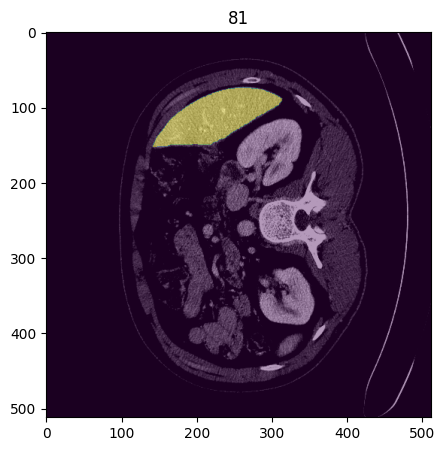

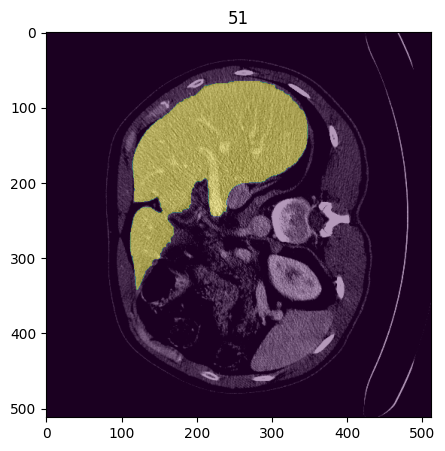

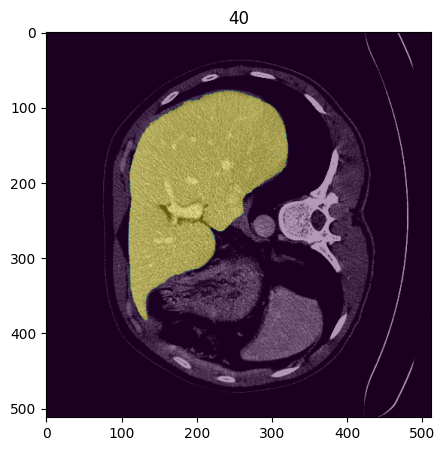

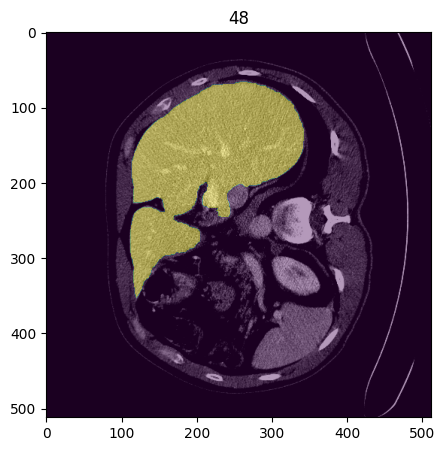

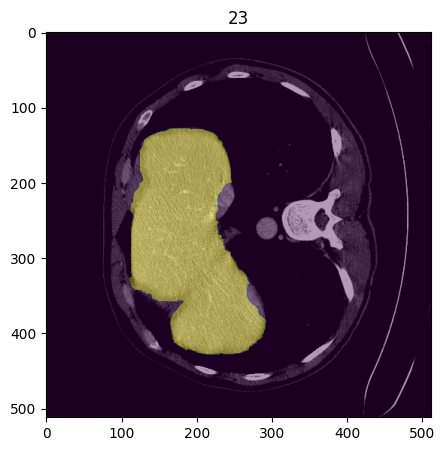

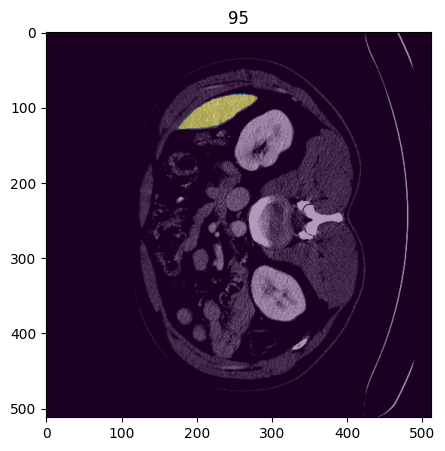

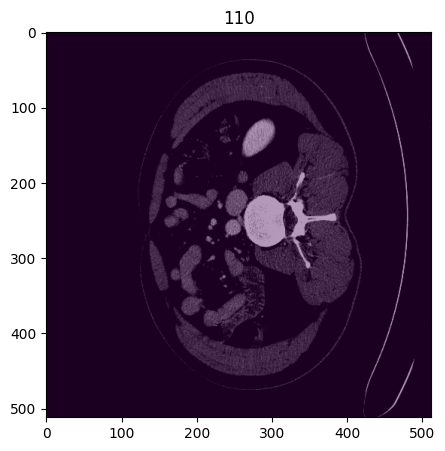

In [ ]:
def show_img(n):
    """
    Show the n-th image with its segmentation mask.

    """
    plt.figure(figsize=(5,5))
    plt.imshow(Image.open(X[0][n]))
    plt.imshow(Image.open(y[0][n]), alpha=0.4)
    plt.title(n)

# let's look at 10 random images
for i in np.random.choice(np.arange(y.shape[0]), 10):
    show_img(i)

In [ ]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3, shuffle=True, random_state=SEED)

# **Определение метрик и модели UNet**

In [ ]:
import tensorflow

from tensorflow.keras.models import Model, load_model
from tensorflow.keras import ops as K

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

tensorflow.keras.backend.set_image_data_format('channels_first')


def dice_coef(y_true, y_pred):
    smooth = 1e-20
    y_true_f = K.cast(y_true, 'float32')
    intersection = K.sum(y_true_f * y_pred)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    smooth = 1e-20
    y_true_f = K.cast(y_true, 'float32')
    intersection = K.sum(y_true_f * y_pred)
    union = K.sum(y_true_f + y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def jaccard_coef_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred)

def unet_1(img_channels, image_rows, image_cols, neurons=16):
    inputs = Input((img_channels, image_rows, image_cols))
    conv1 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    conv5 = Conv2D(neurons*16, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(neurons*16, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
    up6 = Dropout(0.5)(up6)
    conv6 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(neurons*8, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    up7 = Dropout(0.5)(up7)
    conv7 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(neurons*4, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
    up8 = Dropout(0.5)(up8)
    conv8 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(neurons*2, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
    up9 = Dropout(0.5)(up9)
    conv9 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(neurons*1, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Dropout(0.5)(conv9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv10)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer="adam", loss=dice_coef_loss, metrics=[dice_coef])
    return model

In [ ]:
def plot_history(history, scoring='dice_coef'):
    dct = history.history
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(dct['loss'], label='loss')
    ax[0].plot(dct['val_loss'], label='val_loss')
    ax[1].plot(dct[scoring], label=scoring)
    ax[1].plot(dct[f'val_{scoring}'], label=f'val_{scoring}')
    if 'lr' in dct:
        ax[2].plot(dct['lr'], label='lr')
    [a.legend() for a in ax]

# **Подготовка генераторов данных и обучение модели**

In [ ]:
X_train.shape, y_train.shape

w_size = np.array(Image.open(X[0][0])).shape[0]
model_1 = unet_1(1, w_size, w_size, 8)

X_tr, X_val, y_tr, y_val = tts(X_train, y_train, test_size=0.1, shuffle=True, random_state=SEED)

In [ ]:
%%time
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
early_stop = EarlyStopping(patience=30)

gen_train_params = {
    'rotation_range':10,
    'fill_mode':'reflect',
}

idg_train_data = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
                                    **gen_train_params,
                             )
idg_train_mask = ImageDataGenerator(rescale=1./255,
                                    **gen_train_params)

train_gen_params = {
    'x_col': 0,
    'target_size': (512, 512),
    'color_mode': 'grayscale',
    'batch_size': 4,
    'class_mode': None,
    'shuffle': True,
    'seed': SEED,
}
val_gen_params = train_gen_params.copy()
val_gen_params['shuffle'] = False
val_gen_params['batch_size'] = 1

def data_generator(data_generator, mask_generator):
    for data, mask in zip(data_generator, mask_generator):
        yield (data, mask.astype(np.uint8))

data_train_generator = idg_train_data.flow_from_dataframe(X_tr, **train_gen_params)
mask_train_generator = idg_train_mask.flow_from_dataframe(y_tr, **train_gen_params)

train_generator = data_generator(data_train_generator, mask_train_generator)

idg_test_data = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
                                  )
idg_test_mask = ImageDataGenerator(rescale=1./255)
data_test_generator = idg_test_data.flow_from_dataframe(X_val,**val_gen_params)
mask_test_generator = idg_test_mask.flow_from_dataframe(y_val, **val_gen_params)

test_generator = data_generator(data_test_generator, mask_test_generator)

history = model_1.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=X_tr.shape[0] // train_gen_params['batch_size'],
    validation_steps=X_val.shape[0] // val_gen_params['batch_size'],
    verbose=1,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)


Found 77 validated image filenames.
Found 77 validated image filenames.
Found 9 validated image filenames.
Found 9 validated image filenames.
Epoch 1/50
12/19 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - dice_coef: 0.7482 - loss: 0.2518

KeyboardInterrupt: 

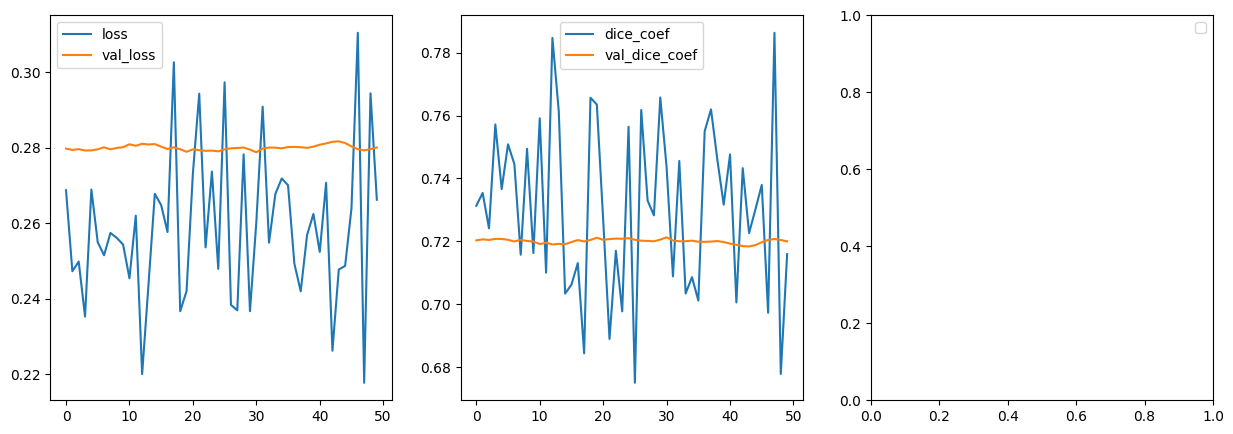

In [ ]:
plot_history(history)

In [ ]:
from google.colab import files

name = 'unet_r.h5'
model_1.save(name)

files.download(name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Предсказания модели**

In [ ]:
def evaluate(x_names, y_names, set_name='evaluating', plot_pairs=0):
    val_gen_params['batch_size'] = 1
    print(set_name)
    dices = []
    jccrs = []
    mdices = []
    mjccrs = []
    data_g = idg_test_data.flow_from_dataframe(x_names, **val_gen_params)
    mask_g = idg_test_mask.flow_from_dataframe(y_names, **val_gen_params)
    for i, image_mask in enumerate(zip(tqdm_notebook(data_g), mask_g)):
        if i > x_names.shape[0] // val_gen_params['batch_size']:
            break
        image, mask = image_mask
        if mask.max() == 0:
            continue
        p = model_1.predict(image).astype('uint8')
        dice = dc(p, mask)
        dices.append(dice)
        try:
            jccr = jc(p, mask)
        except ZeroDivisionError as e:
            jccr = 1
        jccrs.append(jccr)

        if plot_pairs:
            plot_pairs -= 1
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(5,10))
            ax1.imshow(image.squeeze())
            ax1.imshow(mask.squeeze(), alpha=0.5, cmap='autumn')
            ax1.set_title('ground')
            ax2.imshow(image.squeeze())
            ax2.imshow(p.squeeze(), alpha=0.5, cmap='autumn')
            ax2.set_title('predicted, dc={0:.2f}'.format(dice))
            plt.show()

    print('dice:', np.mean(dices))
    print('jccr:', np.mean(jccrs))
    print('-------------')
    return jccr

TR SET
Found 77 validated image filenames.
Found 77 validated image filenames.


  0%|          | 0/77 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


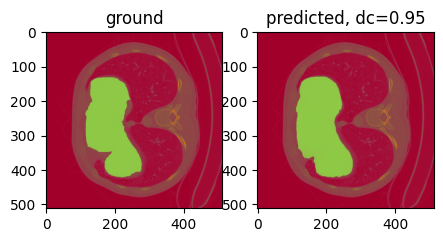

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


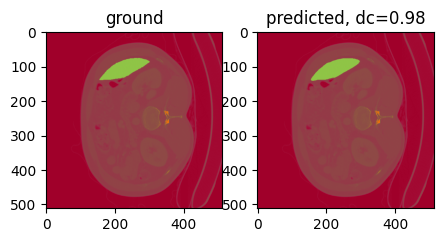

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


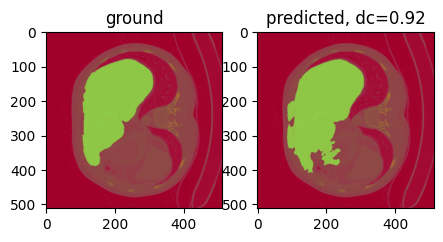

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


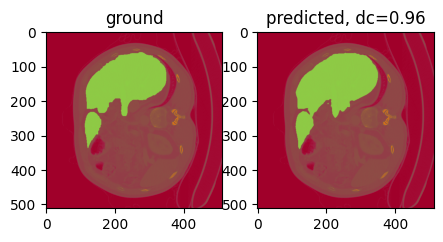

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


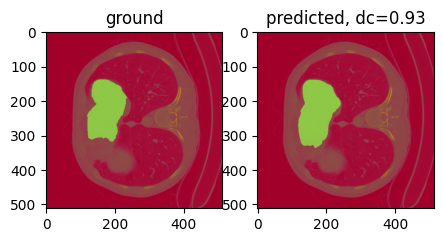

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


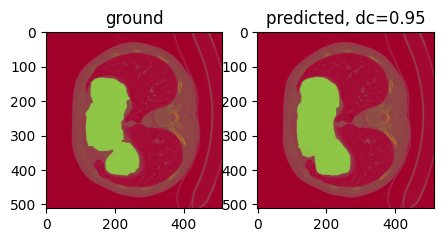

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


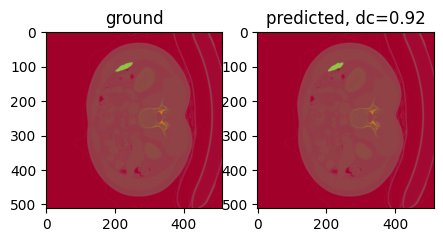

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


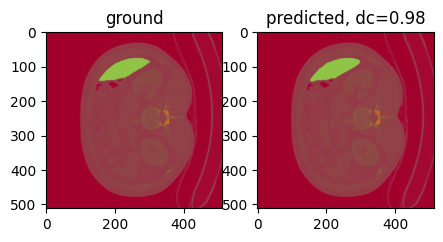

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


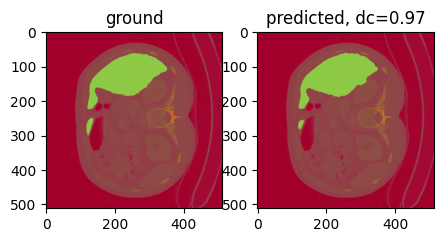

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


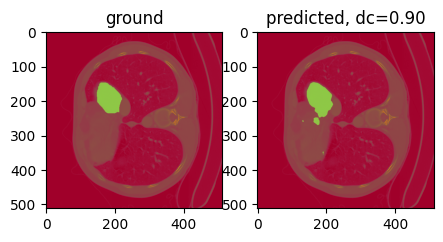

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

  0%|          | 0/9 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


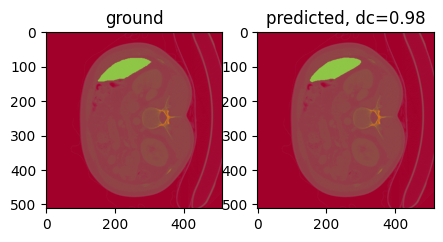

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


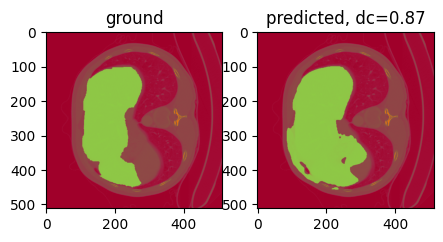

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


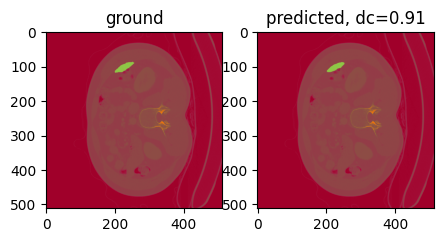

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


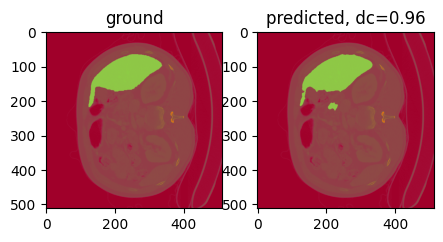

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


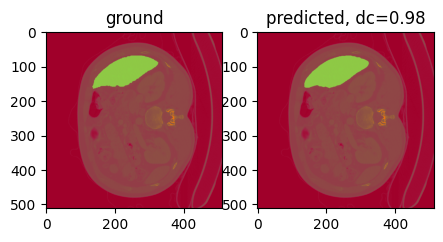

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


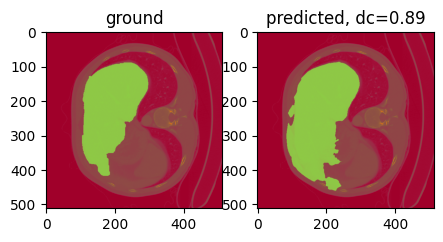

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


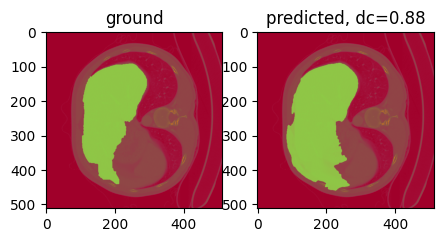

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


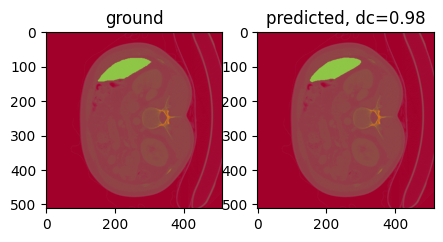

dice: 0.9320660948287094
jccr: 0.8763025379762002
-------------
TEST SET
Found 37 validated image filenames.
Found 37 validated image filenames.


  0%|          | 0/37 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


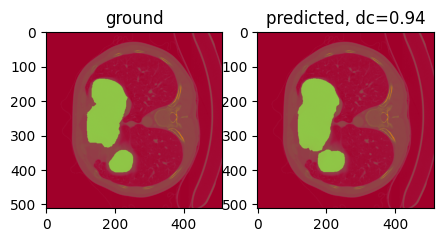

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


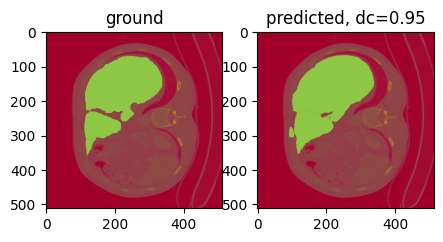

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


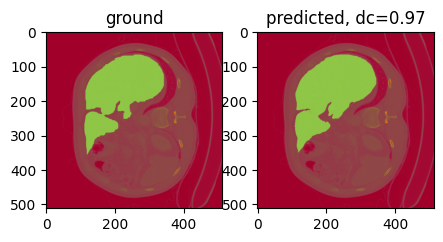

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


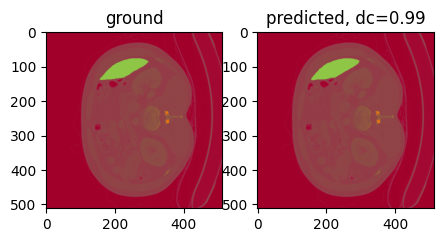

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


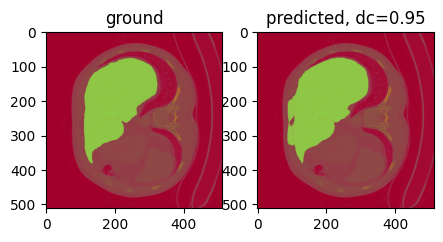

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


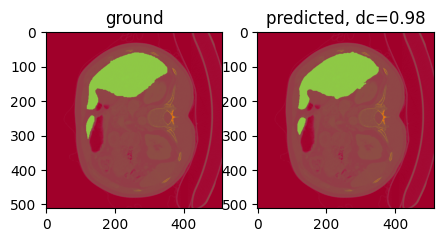

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


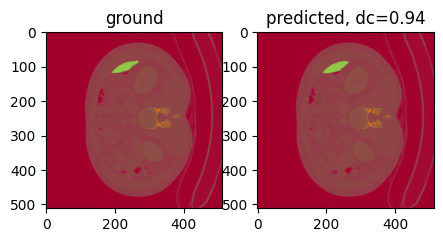

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


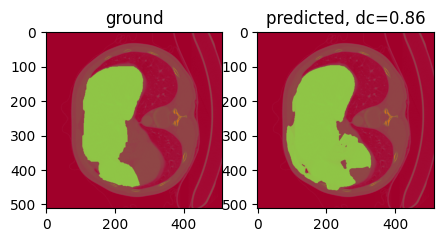

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


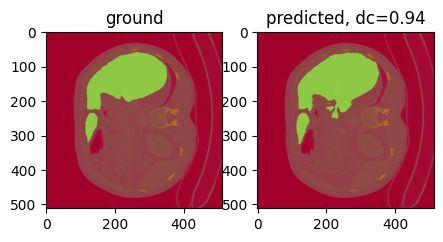

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


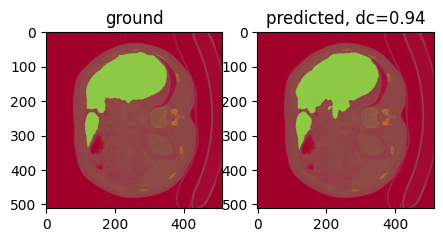

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


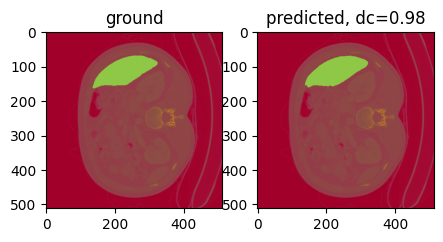

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


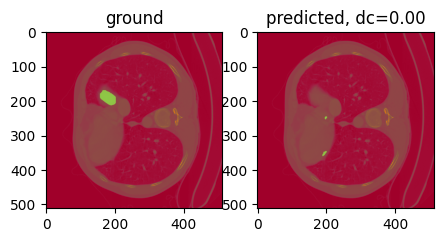

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


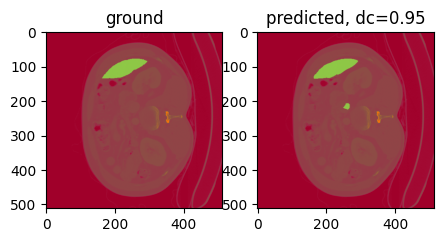

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


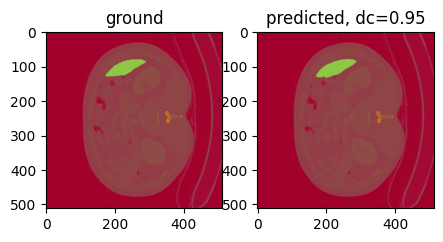

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


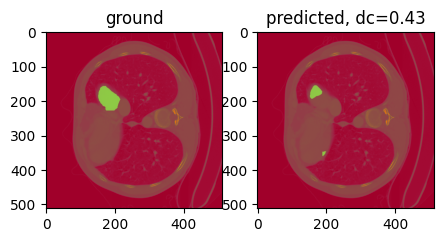

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


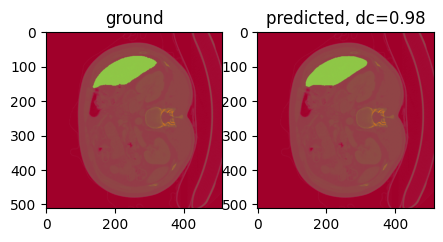

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


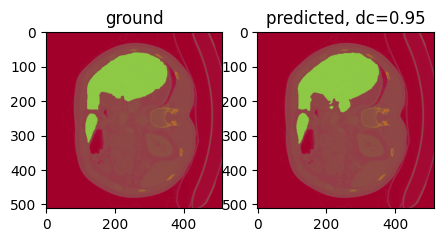

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


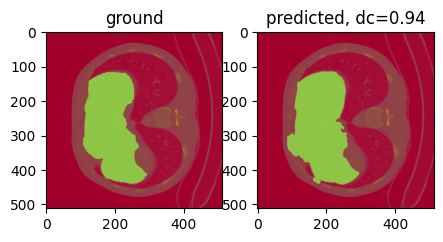

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


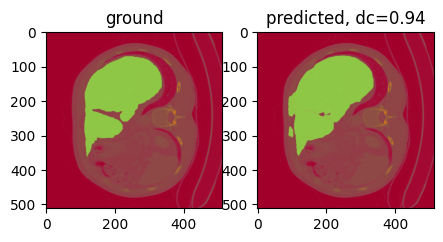

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


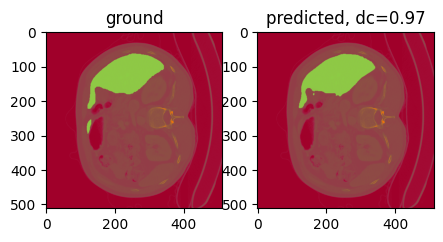

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
dice: 0.8882654118026321
jccr: 0.8358448079665779
-------------
CPU times: user 23.9 s, sys: 3.39 s, total: 27.3 s
Wall time: 27.1 s


0.8822193658954585

In [ ]:
%%time
evaluate(X_tr, y_tr, 'TR SET', 10)
evaluate(X_val, y_val, 'VAL SET', 10)
evaluate(X_test, y_test, 'TEST SET', 20)

# **Предсказания модели(find сontours)**



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
import cv2

def evaluate(x_names, y_names, set_name='evaluating', plot_pairs=0):
    val_gen_params['batch_size'] = 1
    print(set_name)
    dices = []
    jccrs = []

    data_g = idg_test_data.flow_from_dataframe(x_names, **val_gen_params)
    mask_g = idg_test_mask.flow_from_dataframe(y_names, **val_gen_params)

    for i, (image, mask) in enumerate(zip(tqdm_notebook(data_g), mask_g)):
        if i >= len(x_names):
            break
        if mask.max() == 0:
            continue

        p = model_1.predict(image).astype('uint8')
        dice = dc(p, mask)
        dices.append(dice)

        try:
            jccr = jc(p, mask)
        except ZeroDivisionError:
            jccr = 1
        jccrs.append(jccr)

        if plot_pairs > 0:
            plot_pairs -= 1

            mask_8uc1 = (mask.squeeze() * 255).astype(np.uint8)
            pred_8uc1 = (p.squeeze() * 255).astype(np.uint8)

            contours_true, _ = cv2.findContours(mask_8uc1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours_pred, _ = cv2.findContours(pred_8uc1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            ax1.imshow(image.squeeze(), cmap='gray')
            ax1.imshow(mask.squeeze(), alpha=0.5, cmap='autumn')
            for contour in contours_true:
                ax1.plot(contour[:, 0, 0], contour[:, 0, 1], 'b', linewidth=2)
            ax1.set_title('Истинная маска')

            ax2.imshow(image.squeeze(), cmap='gray')
            ax2.imshow(p.squeeze(), alpha=0.5, cmap='autumn')
            for contour in contours_pred:
                ax2.plot(contour[:, 0, 0], contour[:, 0, 1], 'r', linewidth=2)
            ax2.set_title(f'Предсказанная, Dice={dice:.2f}')
            plt.show()

    mean_dice = np.mean(dices)
    mean_jccr = np.mean(jccrs)

    print('Средний Dice:', mean_dice)
    print('Средний Jaccard:', mean_jccr)
    print('-------------')

    return mean_dice, mean_jccr

TR SET
Found 77 validated image filenames.
Found 77 validated image filenames.


  0%|          | 0/77 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


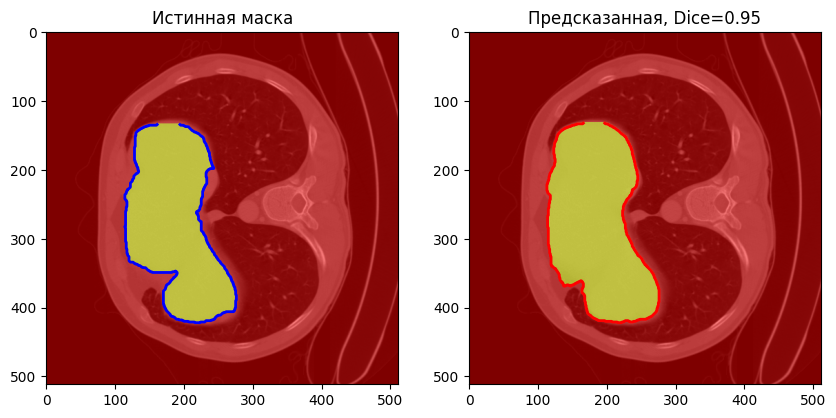

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


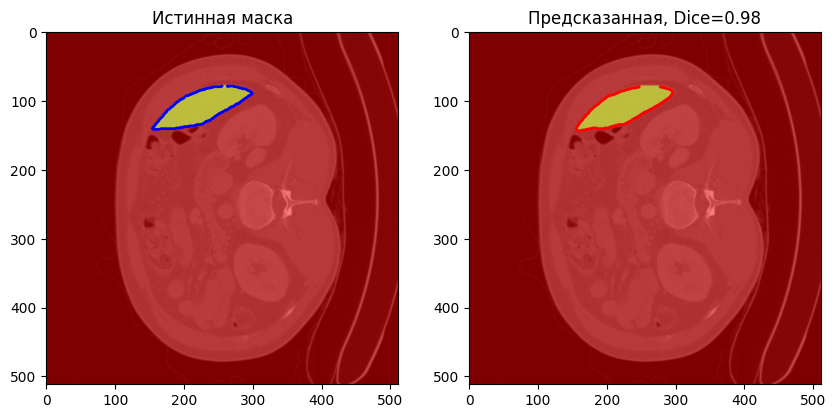

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


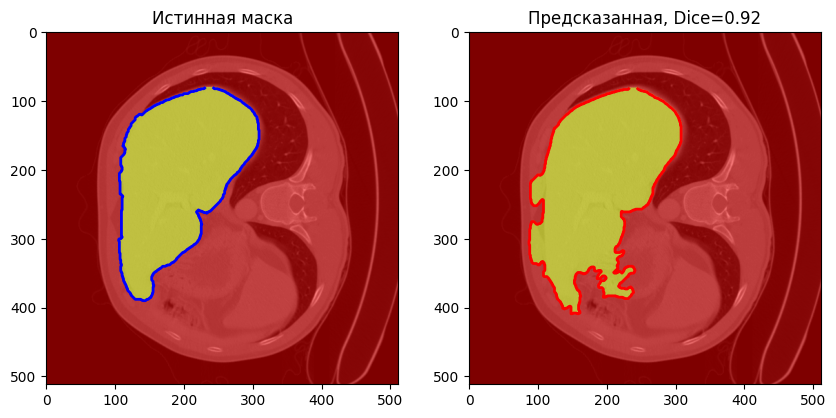

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


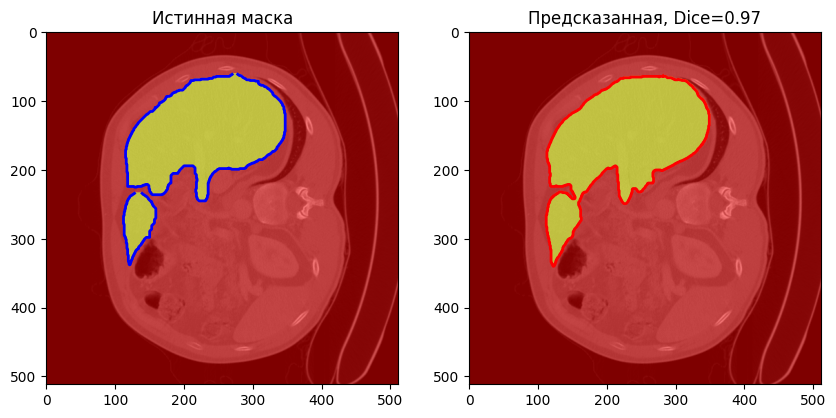

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


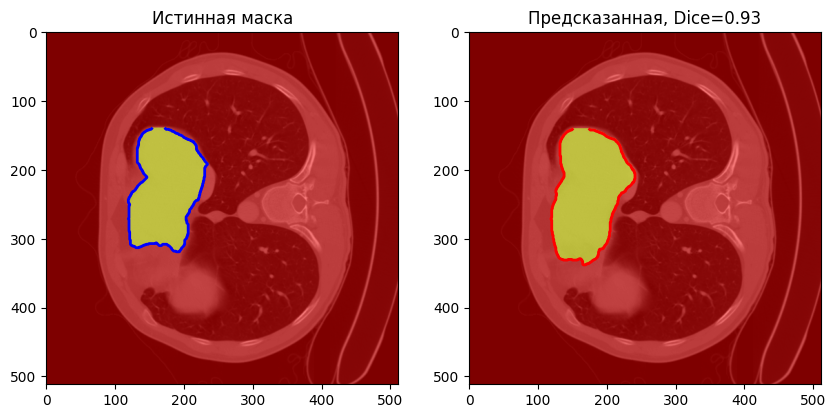

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


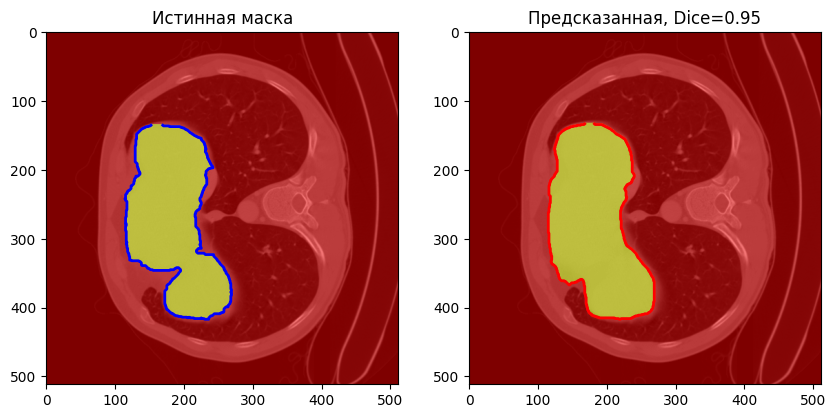

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


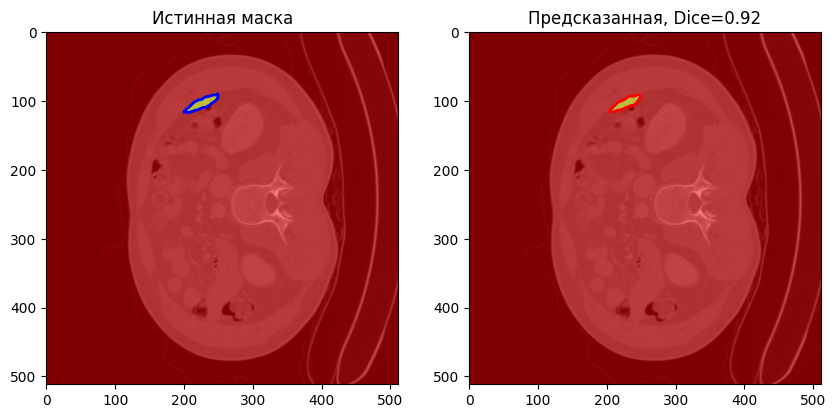

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


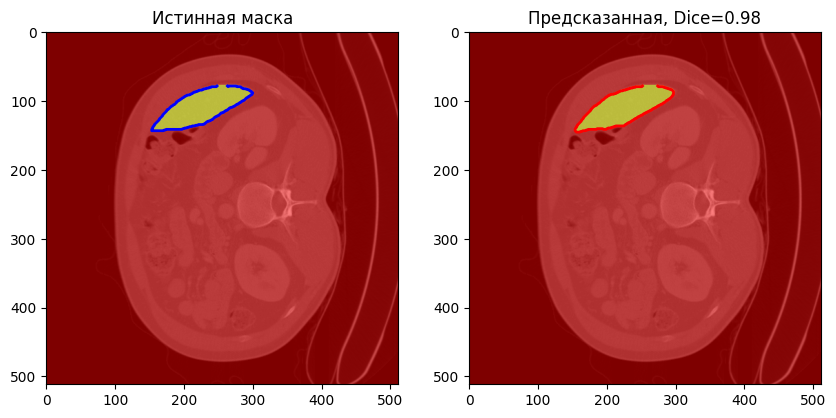

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


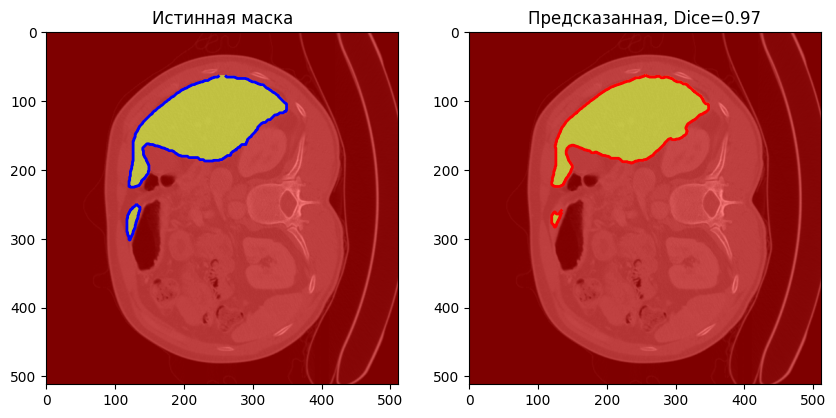

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


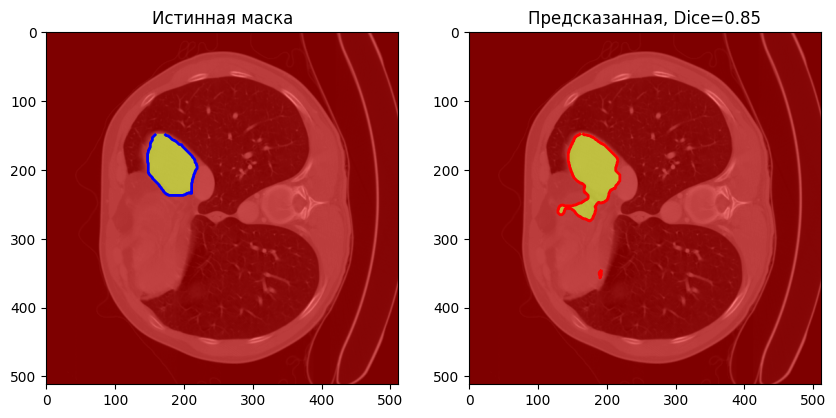

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

  0%|          | 0/9 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


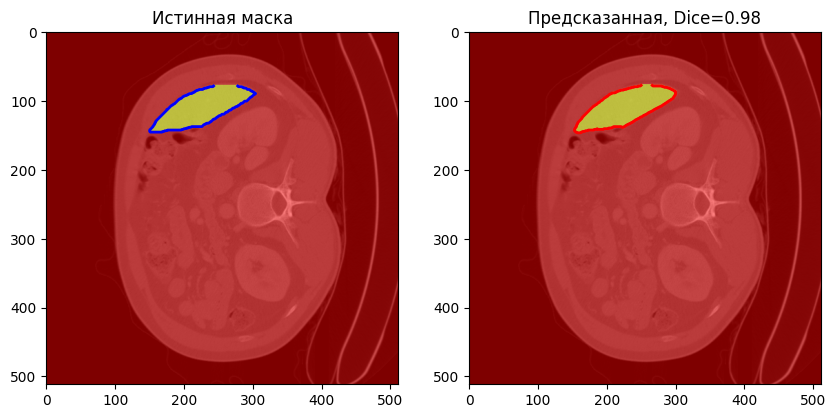

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


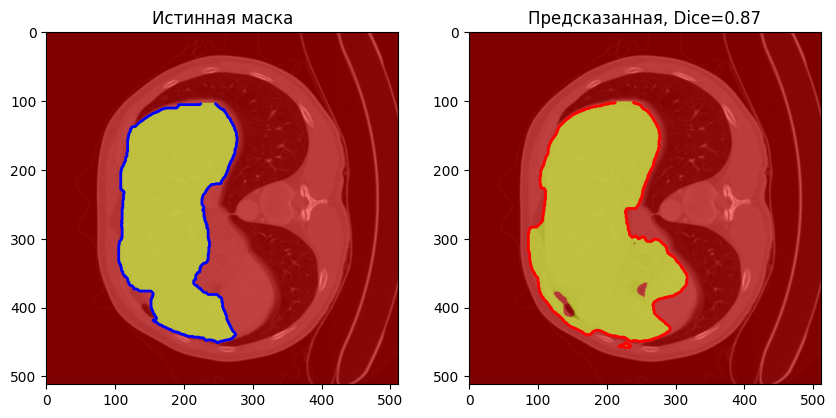

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


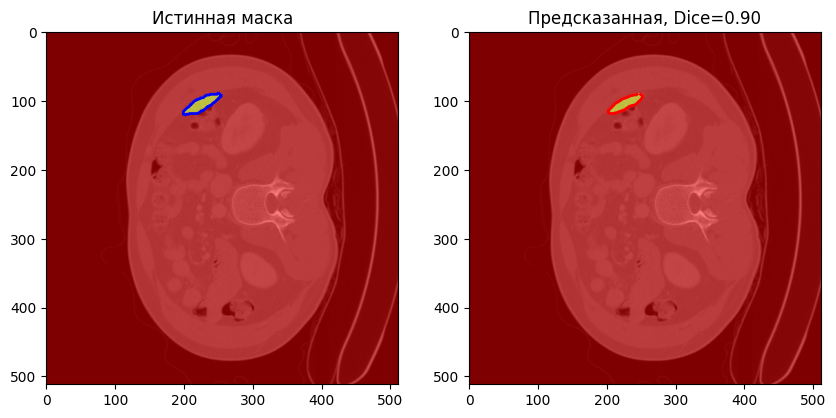

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


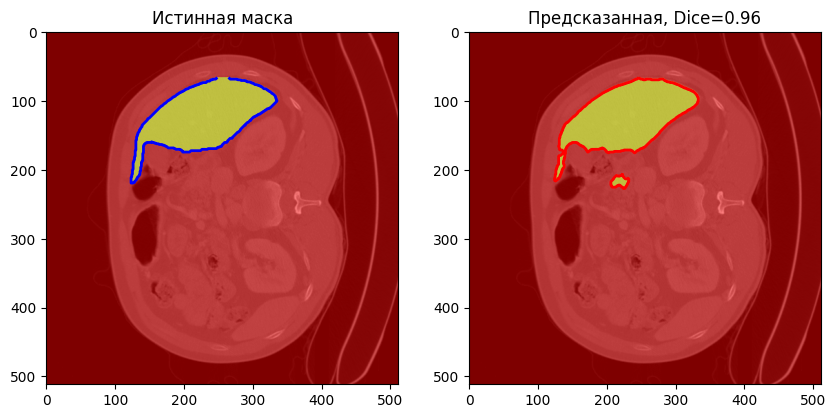

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


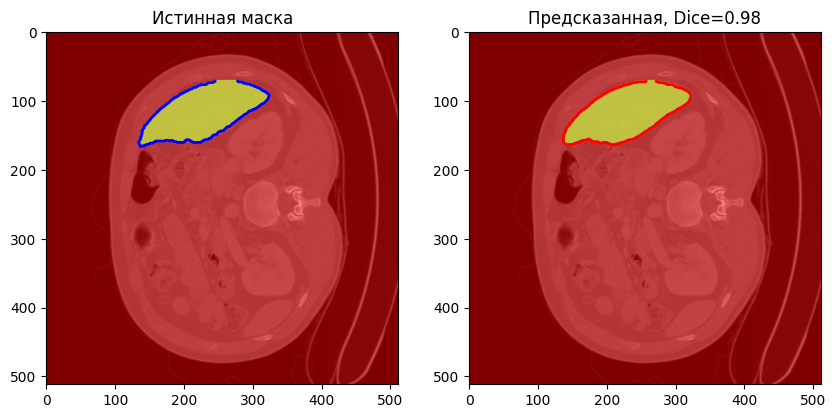

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


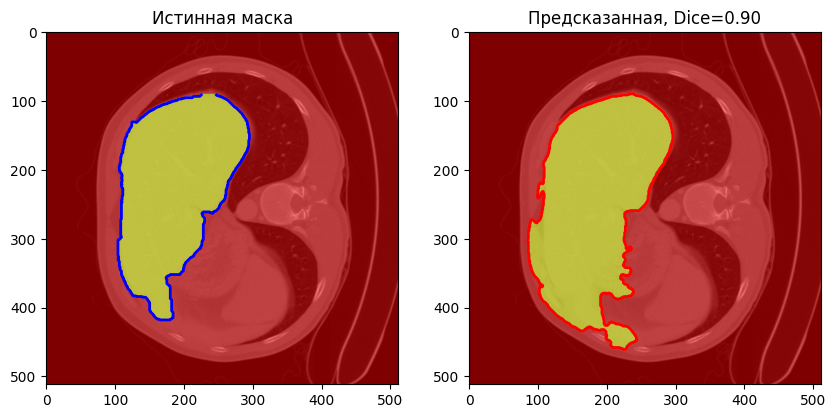

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


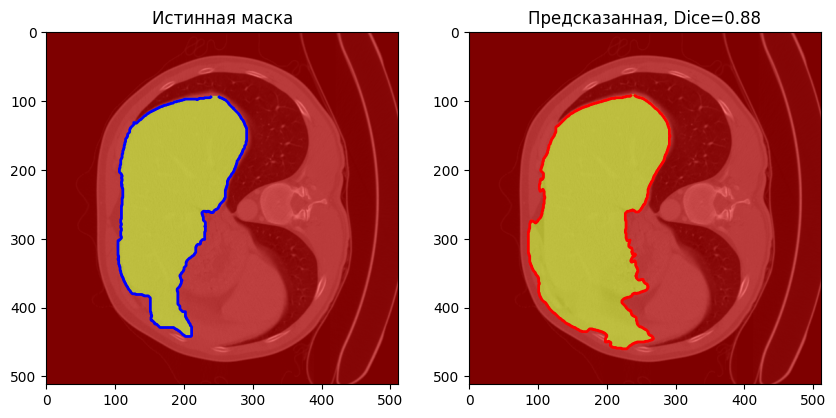

Средний Dice: 0.9254888470869425
Средний Jaccard: 0.8645012217336762
-------------
TEST SET
Found 37 validated image filenames.
Found 37 validated image filenames.


  0%|          | 0/37 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


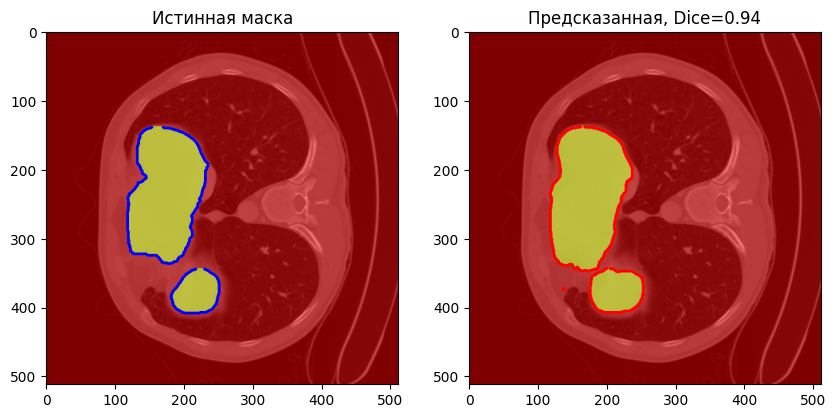

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


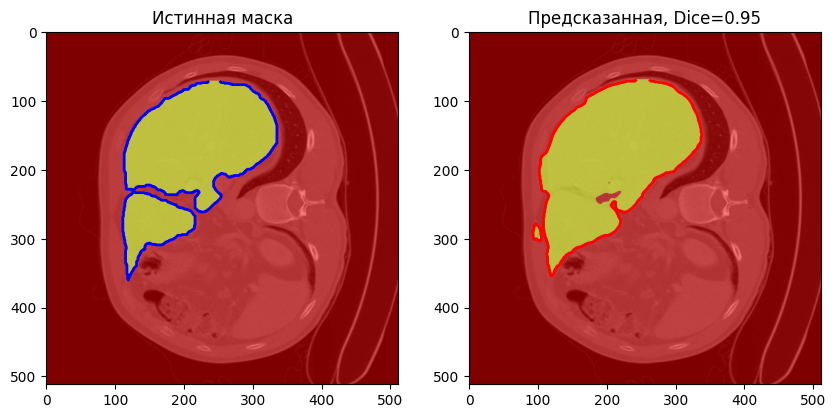

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


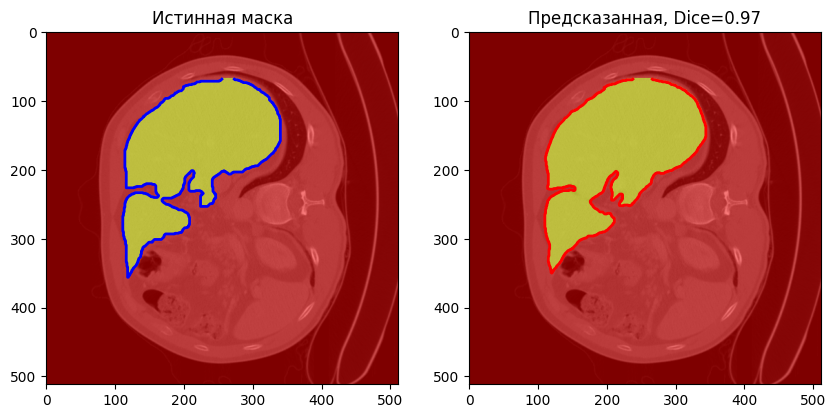

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


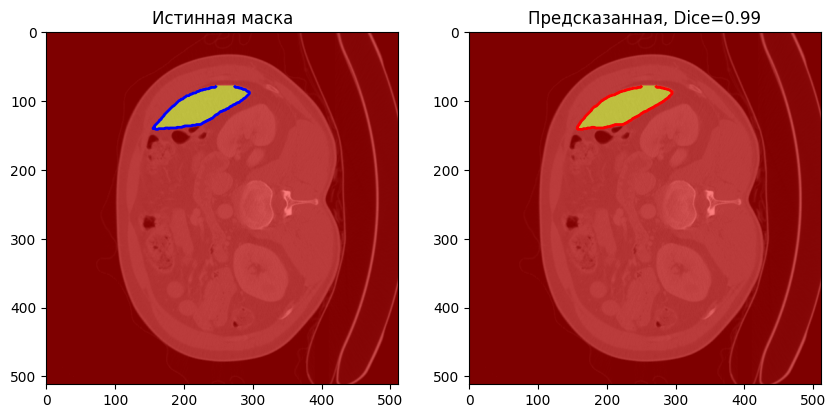

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


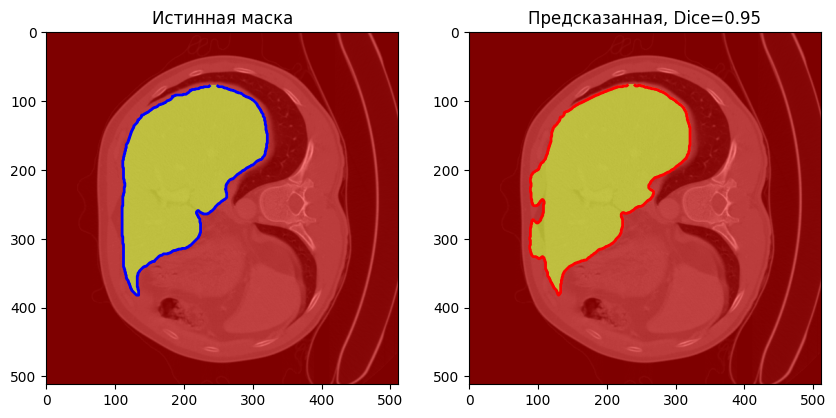

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


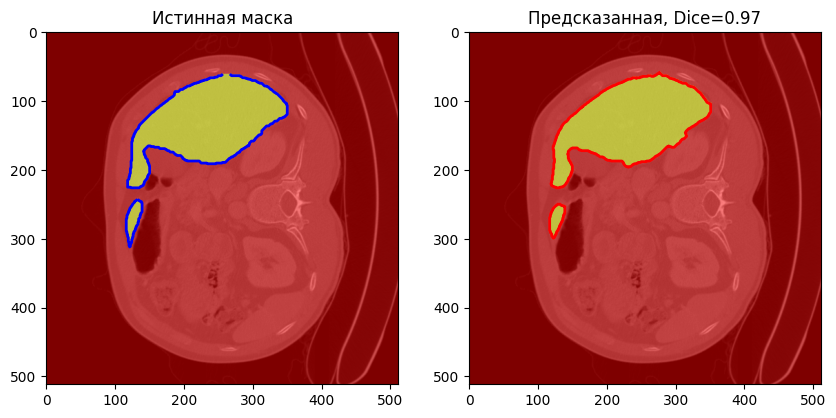

In [ ]:
evaluate(X_tr, y_tr, 'TR SET', 10)
evaluate(X_val, y_val, 'VAL SET', 10)
evaluate(X_test, y_test, 'TEST SET', 30)